<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/land_price_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 地価
- [国土交通省地価公示 鑑定評価書情報CSV](https://www.land.mlit.go.jp/landPrice/CSVDownloadServlet)

In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [5]:
read_columns = [
    '価格時点', '県コード', '市区町村コード', '地域名', '用途区分', '連番', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', 
    '鑑定評価額', '1㎡当たりの価格', '21', '22', '年', '相続税路線価', '倍率', '倍率種別', '所在地番', '住居表示', '仮換地番号', '地積', '内私道分', 
    '形状', '間口', '奥行', '現況', '構造', '地上階数', '地下階数', '周辺の利用状況', '方位', '駅前区分', '道路幅員', '舗装状況', '道路の種類', '側道方位', 
    '側道等接面状況', '水道', 'ガス', '下水道', '交通施設', '距離', '近接区分', '区域区分', '用途地域', '指定建ぺい率', '指定容積率', '防火地域', '自然公園法'
]
use_cols = list(range(len(read_columns)))

In [6]:
df_takuchi = pd.read_csv(
    os.path.join(DIR_NAME, 'original/2022_TAKUCHI_k_13.csv'), 
    encoding='cp932', header=None, usecols=use_cols, names=read_columns
)
print(df_takuchi.shape)

(5188, 58)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (25,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
use_type = {0: '住宅地', 3: '宅地見込地', 5: '商業地', 7: '準工業地', 9: '工業地', 10: '調整区域内宅地', 13: '現況林地', 20: '林地',}
df_takuchi['用途区分'] = df_takuchi['用途区分'].map(use_type)

In [8]:
df_takuchi_extract = df_takuchi[df_takuchi['市区町村コード'] < 200][[
    '地域名', '用途区分', '鑑定評価額', '1㎡当たりの価格', '所在地番', '地積', '交通施設', '距離'
]].rename(columns={'地域名': '市区町村名'}).drop_duplicates(subset='所在地番').reset_index(drop=True)
df_takuchi_extract['市区町村名'] = df_takuchi_extract['市区町村名'] + '区'
print(df_takuchi_extract.shape)
assert df_takuchi_extract['市区町村名'].nunique() == 23

(1594, 8)


In [9]:
df_takuchi_extract['町名'] = df_takuchi_extract['所在地番'].str.extract('(.*?)[１２３４５６７８９]', expand=False)
df_takuchi_extract['町丁目'] = df_takuchi_extract['所在地番'].str.extract('(.*丁目)', expand=False)
df_takuchi_extract.loc[df_takuchi_extract['町丁目'].isna(), '町丁目'] = df_takuchi_extract['町名']

In [10]:
df_takuchi_extract.head(10)

,市区町村名,用途区分,鑑定評価額,1㎡当たりの価格,所在地番,地積,交通施設,距離,町名,町丁目
0,千代田区,住宅地,3140000000,3240000,三番町６番２５,969,半蔵門,500,三番町,三番町
1,千代田区,住宅地,1090000000,2040000,紀尾井町３番２７外,535,永田町,300,紀尾井町,紀尾井町
2,千代田区,住宅地,9400000000,4150000,六番町６番１外,2266,四ツ谷,330,六番町,六番町
3,千代田区,住宅地,223000000,1570000,富士見１丁目８番６,142,飯田橋,360,富士見,富士見１丁目
4,千代田区,住宅地,4560000000,3020000,九段北２丁目６番２６,1511,九段下,450,九段北,九段北２丁目
5,千代田区,住宅地,1080000000,1830000,平河町２丁目２１番１,590,永田町,240,平河町,平河町２丁目
6,千代田区,住宅地,2440000000,3080000,一番町１６番３,792,半蔵門,220,一番町,一番町
7,千代田区,商業地,85100000000,13900000,大手町１丁目１１番外,6119,竹橋,0,大手町,大手町１丁目
8,千代田区,商業地,367000000000,36600000,丸の内２丁目２番１外,10027,東京,0,丸の内,丸の内２丁目
9,千代田区,商業地,143000000,1300000,神田錦町２丁目７番１５,110,竹橋,400,神田錦町,神田錦町２丁目


### 人口マスタ

In [11]:
df_population = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[
    ['地域ID', '市区町村名', '町名', '町丁目', '経度', '緯度']
].set_index(['市区町村名', '町名', '町丁目'])
df_population['地域ID'] = df_population['地域ID'].astype(str)
print(df_population.shape)

(3145, 3)


### 人口データ + 地価

In [12]:
df_pop_takuchi = pd.concat([
    df_population, 
    df_takuchi_extract.groupby(['市区町村名', '町名', '町丁目'])['1㎡当たりの価格'].mean()
], axis=1).reset_index()
print(df_pop_takuchi.shape)

(3156, 7)


In [13]:
# 人口データになくて、地価データがあるレコード
df_pop_takuchi[df_pop_takuchi['地域ID'].isna()]

,市区町村名,町名,町丁目,地域ID,経度,緯度,1㎡当たりの価格
290,中央区,八重洲,八重洲１丁目,NaN,NaN,NaN,15150000.0
291,中央区,八重洲,八重洲２丁目,NaN,NaN,NaN,12800000.0
340,中央区,日本橋蛎殻町,日本橋蛎殻町１丁目,NaN,NaN,NaN,2330000.0
341,中央区,日本橋蛎殻町,日本橋蛎殻町２丁目,NaN,NaN,NaN,1080000.0
548,北区,西ケ原,西ケ原１丁目,NaN,NaN,NaN,871000.0
549,北区,西ケ原,西ケ原３丁目,NaN,NaN,NaN,524000.0
635,千代田区,神田三崎町,神田三崎町３丁目,NaN,NaN,NaN,2275000.0
656,千代田区,神田猿楽町,神田猿楽町２丁目,NaN,NaN,NaN,1600000.0
1367,新宿区,四谷三栄町,四谷三栄町,NaN,NaN,NaN,1112500.0
2162,渋谷区,松濤,松濤１丁目,NaN,NaN,NaN,1860000.0


In [14]:
df_pop_takuchi = df_pop_takuchi[df_pop_takuchi['地域ID'].notna()].reset_index(drop=True)
print(df_pop_takuchi.shape)
print('「1㎡当たりの価格」がない町丁', len(df_pop_takuchi[(df_pop_takuchi['1㎡当たりの価格'].isna())]))

# 「1㎡当たりの価格」がない町丁は、町ごとの平均値で埋める
df_pop_takuchi['町ごとの平均価格'] = df_pop_takuchi.groupby('町名')['1㎡当たりの価格'].transform('mean')
df_pop_takuchi.loc[df_pop_takuchi['1㎡当たりの価格'].isna(), '1㎡当たりの価格'] = df_pop_takuchi['町ごとの平均価格']
print('「1㎡当たりの価格」がない町丁', len(df_pop_takuchi[(df_pop_takuchi['1㎡当たりの価格'].isna())]))

(3145, 7)
「1㎡当たりの価格」がない町丁 1821
「1㎡当たりの価格」がない町丁 505


In [15]:
df_pop_takuchi['緯度2'] = (df_pop_takuchi['緯度'].fillna(0) * 100).astype(int)
df_pop_takuchi['経度2'] = (df_pop_takuchi['経度'].fillna(0) * 100).astype(int)
df_pop_takuchi['緯度経度での平均価格'] = df_pop_takuchi.groupby(['緯度2', '経度2'])['1㎡当たりの価格'].transform('mean').round()
df_pop_takuchi.loc[df_pop_takuchi['1㎡当たりの価格'].isna(), '1㎡当たりの価格'] = df_pop_takuchi['緯度経度での平均価格']

# 「1㎡当たりの価格」がない町丁は、町ごとの平均値で埋める(2回目)
df_pop_takuchi['町ごとの平均価格'] = df_pop_takuchi.groupby('町名')['1㎡当たりの価格'].transform('mean')
df_pop_takuchi.loc[df_pop_takuchi['1㎡当たりの価格'].isna(), '1㎡当たりの価格'] = df_pop_takuchi['町ごとの平均価格']
print('「1㎡当たりの価格」がない町丁', len(df_pop_takuchi[(df_pop_takuchi['1㎡当たりの価格'].isna())]))

「1㎡当たりの価格」がない町丁 30


In [16]:
# 「1㎡当たりの価格」がない町丁は、区ごとの平均値で埋める
df_pop_takuchi['区ごとの平均価格'] = df_pop_takuchi.groupby('市区町村名')['1㎡当たりの価格'].transform('mean')
df_pop_takuchi.loc[df_pop_takuchi['1㎡当たりの価格'].isna(), '1㎡当たりの価格'] = df_pop_takuchi['区ごとの平均価格']
print('「1㎡当たりの価格」がない町丁', len(df_pop_takuchi[(df_pop_takuchi['1㎡当たりの価格'].isna())]))
df_pop_takuchi['1㎡当たりの価格'] = df_pop_takuchi['1㎡当たりの価格'].astype(int)

「1㎡当たりの価格」がない町丁 0


### 地価スコア

In [23]:
def normalize_score(sr_data, high=True, outlier=True):
    score = (sr_data - sr_data.mean())/sr_data.std()
    score = score if high else -score

    if outlier:
        high_s = score.quantile(0.99)
        low_s = score.quantile(0.01)
        score[score > high_s] = high_s
        score[score < low_s] = low_s
    else:
        high_s = score.max()
        low_s = score.min()
        
    return (score - low_s)/(high_s - low_s)


def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

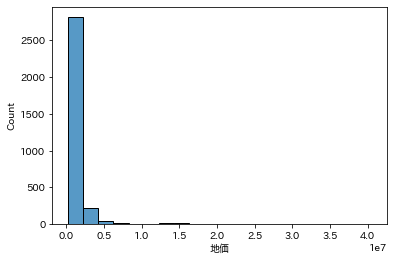

In [40]:
df_score = df_pop_takuchi[['地域ID', '市区町村名', '町丁目', '1㎡当たりの価格']].rename(columns={'1㎡当たりの価格':'地価'})
feature_name = '地価'
sns.histplot(df_score[feature_name], bins=20)
plt.show()

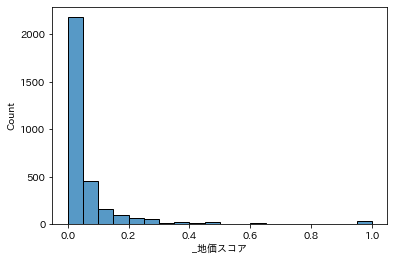

In [41]:
df_score[f'_{feature_name}スコア'] = normalize_score(df_score[feature_name], high=True, outlier=True)
sns.histplot(df_score[f'_{feature_name}スコア'], bins=20)
plt.show()

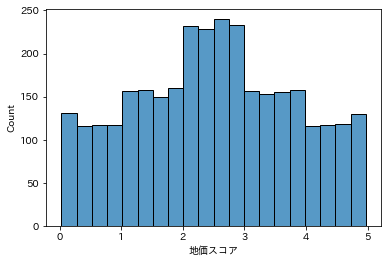

In [42]:
df_score[f'{feature_name}スコア'] = rank_score(df_score[f'_{feature_name}スコア']).round(2)
sns.histplot(df_score[f'{feature_name}スコア'], bins=20)
plt.show()

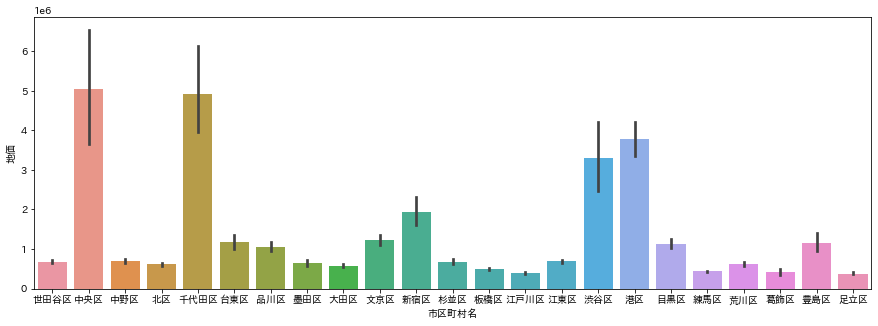

In [43]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y='地価', data=df_score)
plt.show()

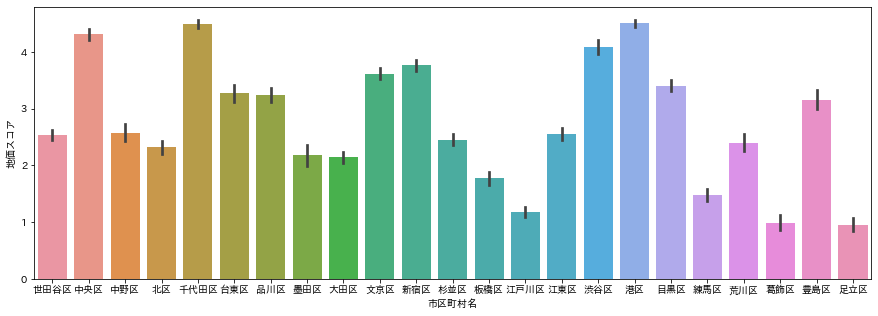

In [44]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y='地価スコア', data=df_score)
plt.show()

### 保存

In [45]:
df_land_score = df_score[['地域ID', '地価', '地価スコア']].reset_index(drop=True)
df_land_score.to_csv(os.path.join(DIR_NAME, 'land_price_score.csv'), index=False)

In [48]:
df_score.sort_values('地価スコア', ascending=False).head(50)

,地域ID,市区町村名,町丁目,地価,_地価スコア,地価スコア
581,101003,千代田区,丸の内１丁目,31700000,1.000000,4.97
372,102012,中央区,銀座５丁目,27315000,1.000000,4.97
371,102011,中央区,銀座４丁目,40600000,1.000000,4.97
370,102010,中央区,銀座３丁目,15900000,1.000000,4.97
369,102009,中央区,銀座２丁目,15966666,1.000000,4.97
368,102008,中央区,銀座１丁目,23508095,1.000000,4.97
2176,113038,渋谷区,道玄坂２丁目,18850000,1.000000,4.97
302,102092,中央区,日本橋１丁目,13715000,1.000000,4.97
291,102002,中央区,八重洲２丁目,21919970,1.000000,4.97
2164,113098,渋谷区,神宮前４丁目,14370000,1.000000,4.97


In [50]:
df_score.sort_values('地価スコア', ascending=False).tail(20)

,地域ID,市区町村名,町丁目,地価,_地価スコア,地価スコア
2732,122163,葛飾区,水元４丁目,211500,0.0,0.03
2730,122161,葛飾区,水元２丁目,211500,0.0,0.03
2764,122182,葛飾区,西水元４丁目,189000,0.0,0.03
2763,122181,葛飾区,西水元３丁目,189000,0.0,0.03
2765,122183,葛飾区,西水元５丁目,189000,0.0,0.03
2766,122184,葛飾区,西水元６丁目,189000,0.0,0.03
2911,121037,足立区,入谷６丁目,226000,0.0,0.03
2761,122179,葛飾区,西水元１丁目,189000,0.0,0.03
3046,121129,足立区,神明１丁目,207000,0.0,0.03
2762,122180,葛飾区,西水元２丁目,189000,0.0,0.03
